# Burger equation in 1D (PINN & SPINN)

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns. We see that, without any specific tuning the SPINN offers an important gain in speed and precision of the solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 1]
]
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

Create the SPINN

In [6]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r]
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [7]:
init_nn_params_pinn = u_pinn.init_params()
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object. Note that the SPINN requires that the batches along each input dimension (here `t` and `x`) be of same length.

In [8]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 100
temporal_batch_size = 100
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

Let's plot the initial condition

## Model parameters

In [9]:
nu = 1 / (100 * jnp.pi)

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params_pinn = {
    "nn_params":init_nn_params_pinn,
    "eq_params":{
        "nu":nu
    }
}
init_params_spinn = {
    "nn_params":init_nn_params_spinn,
    "eq_params":{
        "nu":nu
    }
}

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

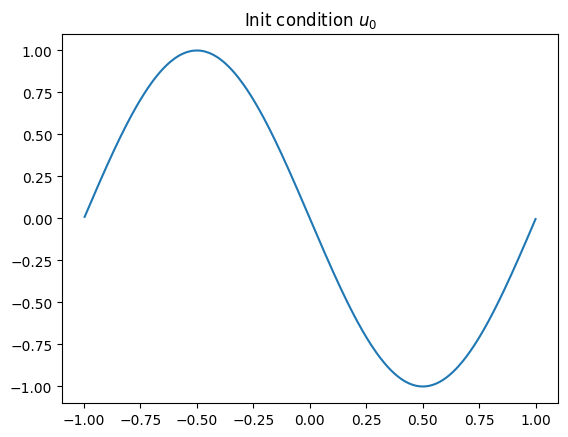

In [11]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

In [12]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)
loss_weights = {"dyn_loss":1, "initial_condition":100, "boundary_loss":1}

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)

In [29]:
loss_weights = {"dyn_loss":1, "initial_condition":10, "boundary_loss":1}

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

### Train the PINN and plot loss values and solution

In [14]:
params_pinn = init_params_pinn
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 30000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter
)

  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 0: loss value = 41.59727096557617
Iteration 1000: loss value = 1.5818207263946533
Iteration 2000: loss value = 0.9388525485992432
Iteration 3000: loss value = 1.0801886320114136
Iteration 4000: loss value = 1.0186502933502197
Iteration 5000: loss value = 0.8265243768692017
Iteration 6000: loss value = 0.6853781938552856
Iteration 7000: loss value = 0.7432224154472351
Iteration 8000: loss value = 0.5415804982185364
Iteration 9000: loss value = 0.6115500926971436
Iteration 10000: loss value = 0.5444085001945496
Iteration 11000: loss value = 0.5959161520004272
Iteration 12000: loss value = 0.5212726593017578
Iteration 13000: loss value = 0.3119886517524719
Iteration 14000: loss value = 0.30868858098983765
Iteration 15000: loss value = 0.3658442497253418
Iteration 16000: loss value = 0.5263796448707581
Iteration 17000: loss value = 0.5072194337844849
Iteration 18000: loss value = 0.41634559631347656
Iteration 19000: loss value = 0.4561387002468109
Iteration 20000: loss value = 0.

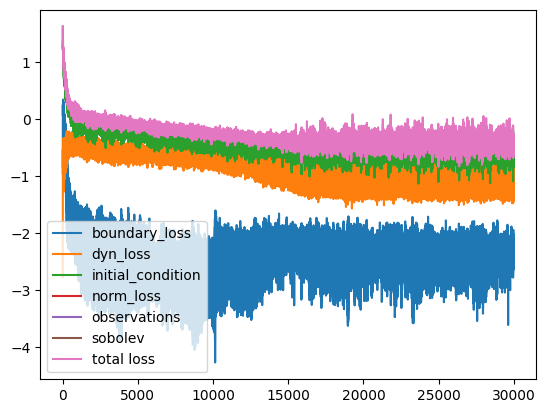

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

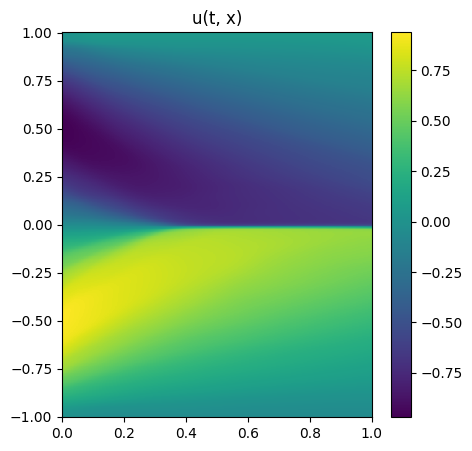

In [16]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

u_est_pinn = partial(u_pinn, u_params=params_pinn["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

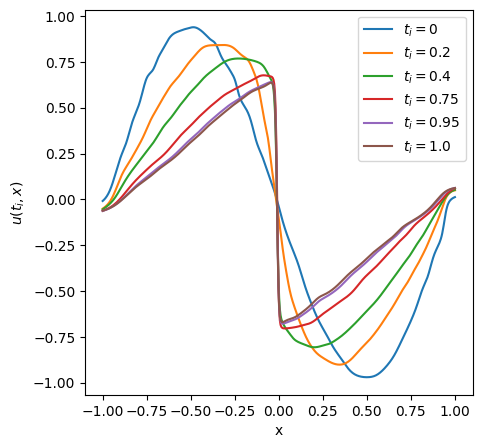

In [17]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.data.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices,  figsize=(5, 5))

### Train the SPINN and plot loss values and solution

In [30]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 30000
params_spinn, total_loss_list_spinn, loss_by_term_dict_spinn, _, _, _, _ = jinns.solve(
    init_params=params_spinn,
    data=train_data,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter
)

Iteration 0: loss value = 8.3115234375


  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.5369646549224854
Iteration 2000: loss value = 0.32285040616989136
Iteration 3000: loss value = 0.29300445318222046
Iteration 4000: loss value = 0.2648681402206421
Iteration 5000: loss value = 0.27686065435409546
Iteration 6000: loss value = 0.23602423071861267
Iteration 7000: loss value = 0.26077893376350403
Iteration 8000: loss value = 0.1770322471857071
Iteration 9000: loss value = 0.22089073061943054
Iteration 10000: loss value = 0.37050101161003113
Iteration 11000: loss value = 0.2019258439540863
Iteration 12000: loss value = 0.19134071469306946
Iteration 13000: loss value = 0.2597481608390808
Iteration 14000: loss value = 0.16081812977790833
Iteration 15000: loss value = 0.15298587083816528
Iteration 16000: loss value = 0.1413116753101349
Iteration 17000: loss value = 0.1876002848148346
Iteration 18000: loss value = 0.12074235081672668
Iteration 19000: loss value = 0.10228968411684036
Iteration 20000: loss value = 0.37870094180107117
Iteration 21000:

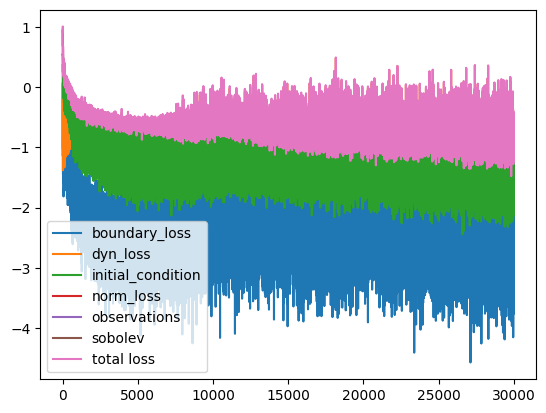

In [31]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

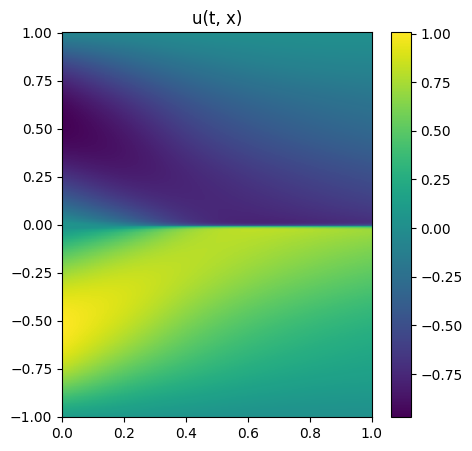

In [32]:
u_est_spinn = partial(u_spinn, u_params=params_spinn["nn_params"])

jinns.data.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)", spinn=True)

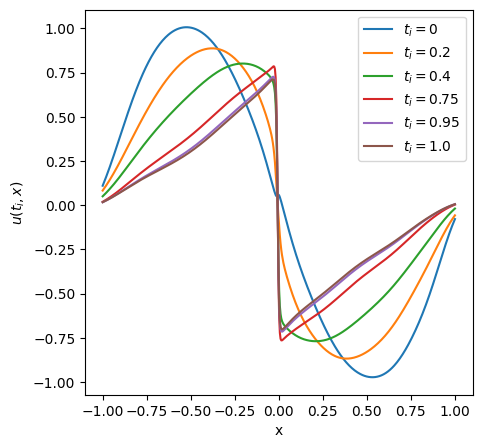

In [33]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.data.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, spinn=True,  figsize=(5, 5))

## Conclusion

We have been able to solve the Burger PDE with jinns both with a PINN and SPINN. While the SPINN solution looks more accurate, we also obtain it approximately 10 times faster:

- PINN's progress bar: 30000/30000 [13:53<00:00, 36.09it/s]
 
- SPINN's progress bar: 30000/30000 [01:11<00:00, 407.17it/s]

(Times obtained on GPU Nvidia T600)

One could still improve SPINN's solution by tuning the network architecture and batch size as we here used default parameters. Since SPINNs are fast, one could also afford more iterations, possibly by finetuning with LBFGS.

## Other

Save the estimated solution grid values

In [22]:
# x = test_data.omega.sort(axis=0).squeeze()
# t = test_data.times.sort(axis=0).squeeze()
# tv, xv = jnp.meshgrid(t, x)
# jnp.save("burger_t_grid.npy", tv)
# jnp.save("burger_x_grid.npy", xv)

# values = u_est_fp(tv.reshape((nt * n, 1)), xv.reshape((nt * n, 1)))
# grid = values.reshape(n, nt)
# jnp.save("burger_solution_grid.npy",
#     jnp.stack(
#         [tv, xv, grid],
#         axis=-1
#     )
# )
